In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# average/extrapolate the line segments to map out the full extent of the lane
def draw_lines2(img, lines, color=[255, 0, 0], thickness=4):  
    plusSlope = plusXA = plusYA  = []
    minusSlope = minusXA = minusYA  = []

    for line in lines: 
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if slope > 0:
                plusSlope.append(slope)
                plusXA.append((x2 - x1)/2 + x1)
                plusYA.append((y2 - y1)/2 + y1)
            elif slope < 0:
                minusSlope.append(slope)
                minusXA.append((x2 - x1)/2 + x1)
                minusYA.append((y2 - y1)/2 + y1)

    avgPlusSlope = sum(plusSlope) / len(plusSlope)
    avgPlusXA = sum(plusXA) / len(plusXA)
    avgPlusYA = sum(plusYA) / len(plusYA)
    PlusIntercept = (avgPlusYA - avgPlusSlope * avgPlusXA)

    avgMinusSlope = sum(minusSlope) / len(minusSlope)
    avgMinusXA = sum(minusXA) / len(minusXA)
    avgMinusYA = sum(minusYA) / len(minusYA)
    MinusIntercept = (avgMinusYA - avgMinusSlope * avgMinusXA)
    
    width = img.shape[0]

    print("x=", (0, int(PlusIntercept)),",",  (width, int(avgPlusSlope * width + PlusIntercept)))
    cv2.line(img, (0, int(PlusIntercept)), (width, int(avgPlusSlope * width + PlusIntercept)), color, thickness)
    print("x=", (0, int(MinusIntercept)), (width, int(avgMinusSlope * width + MinusIntercept)))
    cv2.line(img, (0, int(MinusIntercept)), (width, int(avgMinusSlope * width + MinusIntercept)), color, thickness)
    
# average/extrapolate the line segments to map out the full extent of the lane
def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    leftLane = get_Lanes(lines, isLeft=True)
    leftLane = extend_Lane(leftLane, img.shape)

    rightLane = get_Lanes(lines, isLeft=False)
    rightLane = extend_Lane(rightLane, img.shape)

    lanelines = [leftLane, rightLane]

    for line in lanelines:
        if len(line) > 0:
            for x1, y1, x2, y2 in [line]:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
slope_10 = math.pi/18
min_slope = math.tan(slope_10)
max_slope = math.tan(slope_10 *  8)

def isValidSlope(slope, isLeft):
    if isLeft: 
        return (min_slope <= slope <= max_slope)
    return (-max_slope <= slope <= -min_slope)


# Find valid lines in the slope 10 to 80 degree line
def get_Lanes(lines, isLeft):
    validLanes = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1)/(x2 - x1)
        validSlope = isValidSlope(slope, isLeft)
        if validSlope:
            validLanes.append(line[0])
         
    return validLanes

# Extend left and right lane 
def extend_Lane(lines, shape):
    points = np.array(lines)
    if points.size == 0:
        return []
    
    xes = np.ndarray.flatten(points[:, 0:4:2])
    yes = np.ndarray.flatten(points[:, 1:4:2])
    slope, intercept = np.polyfit(xes, yes, 1)
    
    ex2 = shape[1]
    ey2 = slope * ex2 + intercept

    return list(map(int, [0, intercept, ex2, ey2]))
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)    
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


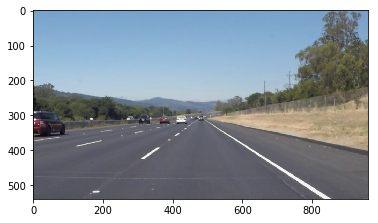

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

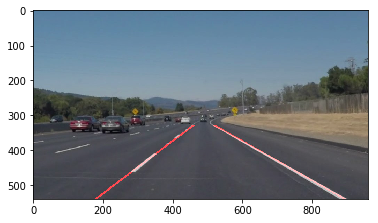

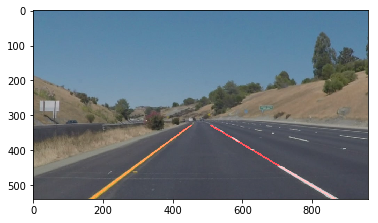

In [5]:
def imshow(img, gray=True, title=""):
    plt.figure()
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
        
def findLane(initial_img):
    img = np.copy(initial_img)
    img = grayscale(img)
    img = canny(img, low_threshold=50, high_threshold=150)  
    img = gaussian_blur(img, kernel_size=3)  
    
    imshape = img.shape  
    vertices = np.array([[(0 ,imshape[0]) ,(450, 330), (530, 330), (imshape[1] ,imshape[0])]], dtype=np.int32)
    
    img = region_of_interest(img, vertices)
    #imshow(img)
    
    img = hough_lines(img, rho=2, theta=np.pi/180, threshold=50, min_line_len=50, max_line_gap=10)
    img = region_of_interest(img, vertices)
    img = weighted_img(img, initial_img, α=0.8, β=1., λ=0.)

    return img

img = mpimg.imread("test_images/test.jpg")
img = findLane(img)
imshow(img)

img = mpimg.imread("test_images/solidYellowCurve2.jpg")
img = findLane(img)
imshow(img)


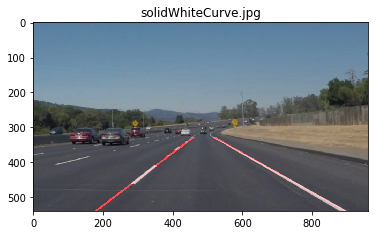

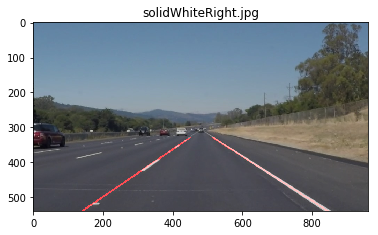

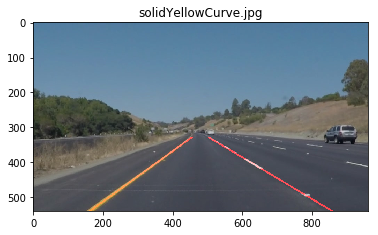

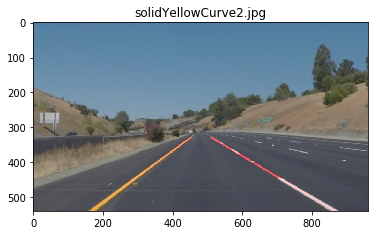

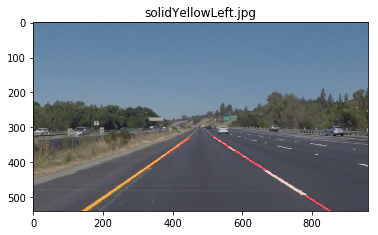

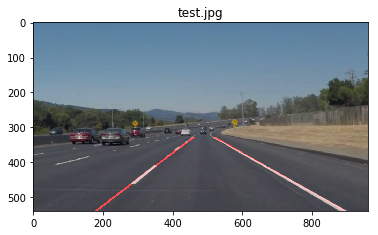

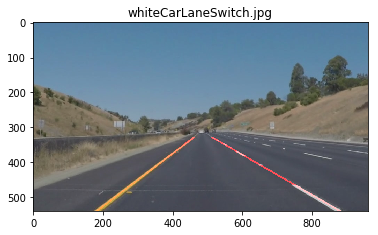

In [6]:
import os
os.listdir("test_images/")
for file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + file)
    img = findLane(img)
    imshow(img, title=file)
    mpimg.imsave("test_images_output/" + file, img)

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    return findLane(image)

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▌| 221/222 [00:10<00:00, 21.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.1 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))